# Bayesian Statistics - The Challenger Disaster

This Notebook is an excerpt of the excellent 'Bayesian Methods for Hackers'. For the whole book, check out https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers.

**Note:**  This Notebook requires the package *pymc*, version 3 or 4. I have only been able to install PyMC3 and PyMC4 using Anaconda, 

Thomas Haslwanter, Nov-2022

On January 28, 1986, the twenty-fifth flight of the U.S. space shuttle program ended in disaster when one of the rocket boosters of the Shuttle Challenger exploded shortly after lift-off, killing all seven crew members. The presidential commission on the accident concluded that it was caused by the failure of an O-ring in a field joint on the rocket booster, and that this failure was due to a faulty design that made the O-ring unacceptably sensitive to a number of factors including outside temperature. Of the previous 24 flights, data were available on failures of O-rings on 23, (one was lost at sea), and these data were discussed on the evening preceding the Challenger launch, but unfortunately only the data corresponding to the 7 flights on which there was a damage incident were considered important and these were thought to show no obvious trend. The data are shown below:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from urllib.request import urlopen

url_base = 'https://raw.githubusercontent.com/thomas-haslwanter/statsintro_python/master/ipynb/Data/data_bayes/'
inFile = 'challenger_data.csv'
url = url_base + inFile
challenger_data = np.genfromtxt(urlopen(url), skip_header=1, usecols=[1, 2],
                                missing_values='NA', delimiter=',')
#drop the NA values
challenger_data = challenger_data[~np.isnan(challenger_data[:, 1])]

#plot it, as a function of tempature (the first column)
print("Temp (F), O-Ring failure?")
print(challenger_data)

Temp (F), O-Ring failure?
[[66.  0.]
 [70.  1.]
 [69.  0.]
 [68.  0.]
 [67.  0.]
 [72.  0.]
 [73.  0.]
 [70.  0.]
 [57.  1.]
 [63.  1.]
 [70.  1.]
 [78.  0.]
 [67.  0.]
 [53.  1.]
 [67.  0.]
 [75.  0.]
 [70.  0.]
 [81.  0.]
 [76.  0.]
 [79.  0.]
 [75.  1.]
 [76.  0.]
 [58.  1.]]


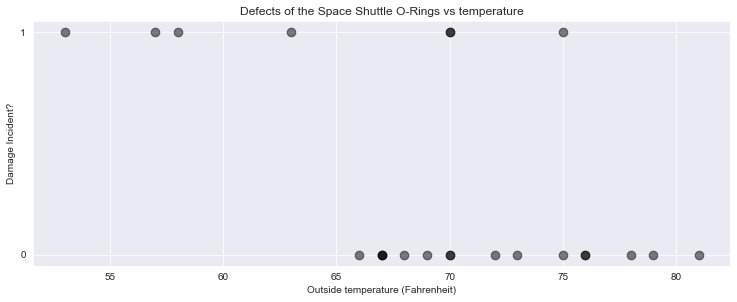

In [2]:
%matplotlib inline
from IPython.core.pylabtools import figsize

sns.set_style('darkgrid')
np.set_printoptions(precision=3, suppress=True)

figsize(12.5, 4.5)
plt.scatter(challenger_data[:, 0], challenger_data[:, 1], s=75, color="k",
            alpha=0.5)
plt.yticks([0, 1])
plt.ylabel("Damage Incident?")
plt.xlabel("Outside temperature (Fahrenheit)")
plt.title("Defects of the Space Shuttle O-Rings vs temperature");

In this model, 𝛽 is the variable we are uncertain about. Below is the function plotted for 𝛽=1,3,−5.It looks clear that the probability of damage incidents occurring increases as the outside temperature decreases. We are interested in modeling the probability here because it does not look like there is a strict cutoff point between temperature and a damage incident occurring. The best we can do is ask "At temperature t, what is the probability of a damage incident?". The goal of this example is to answer that question.

We need a function of temperature, call it p(t), that is bounded between 0 and 1 (so as to model a probability) and changes from 1 to 0 as we increase temperature. There are actually many such functions, but the most popular choice is the *logistic function*.


$$p(t) = \frac{1}{ 1 + e^{ \;\beta t + \alpha } } $$

In this model, the variable $\beta$ that describes how quickly the function changes from 1 to 0, and $\alpha$ indicates the location of this change. For example

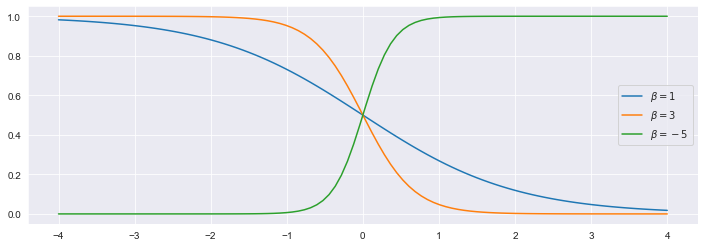

In [3]:
figsize(12, 4)

def logistic(x, beta):
    return 1.0 / (1.0 + np.exp(beta * x))

x = np.linspace(-4, 4, 100)
plt.plot(x, logistic(x, 1), label=r"$\beta = 1$")
plt.plot(x, logistic(x, 3), label=r"$\beta = 3$")
plt.plot(x, logistic(x, -5), label=r"$\beta = -5$")
plt.legend();

But something is missing. In the plot of the logistic function, the probability changes only near zero, but in our data above the probability changes around 65 to 70. We need to add a *bias* term to our logistic function:

$$p(t) = \frac{1}{ 1 + e^{ \;\beta t + \alpha } } $$

Some plots are below, with differing $\alpha$.

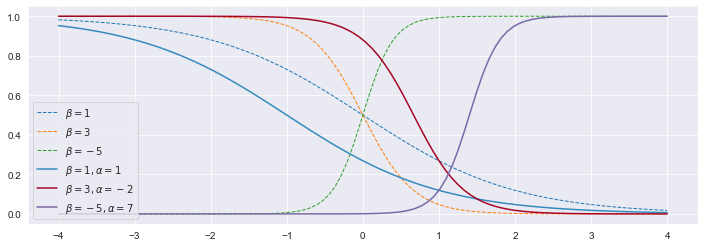

In [4]:
def logistic(x, beta, alpha=0):
    return 1.0 / (1.0 + np.exp(np.dot(beta, x) + alpha))

x = np.linspace(-4, 4, 100)

plt.plot(x, logistic(x, 1), label=r"$\beta = 1$", ls="--", lw=1)
plt.plot(x, logistic(x, 3), label=r"$\beta = 3$", ls="--", lw=1)
plt.plot(x, logistic(x, -5), label=r"$\beta = -5$", ls="--", lw=1)

plt.plot(x, logistic(x, 1, 1), label=r"$\beta = 1, \alpha = 1$",
         color="#348ABD")
plt.plot(x, logistic(x, 3, -2), label=r"$\beta = 3, \alpha = -2$",
         color="#A60628")
plt.plot(x, logistic(x, -5, 7), label=r"$\beta = -5, \alpha = 7$",
         color="#7A68A6")

plt.legend(loc="lower left");

Adding a constant term $\alpha$ amounts to shifting the curve left or right (hence why it is called a *bias*).

Let's start modeling this in PyMC3. The $\beta, \alpha$ parameters have no reason to be positive, bounded or relatively large, so they are best modeled by a *Normal random variable*.

## Perform the MCMC-simulations

### Theano

The majority of the heavy lifting done by PyMC3 is taken care of with the `theano` package. The notation in `theano` is remarkably similar to NumPy. It also supports many of the familiar computational elements of NumPy. However, while NumPy directly executes computations, e.g. when you run `a + b`, `theano` instead builds up a "compute graph" that tracks that you want to perform the `+` operation on the elements `a` and `b`. Only when you `eval()` a `theano` expression does the computation take place (i.e. `theano` is lazy evaluated). Once the compute graph is built, we can perform all kinds of mathematical optimizations (e.g. simplifications), compute gradients via autodiff, compile the entire graph to C to run at machine speed, and also compile it to run on the GPU. PyMC3 is basically a collection of `theano` symbolic expressions for various probability distributions that are combined to one big compute graph making up the whole model log probability, and a collection of inference algorithms that use that graph to compute probabilities and gradients. For practical purposes, what this means is that in order to build certain models we sometimes have to use `theano`.

Let's write some PyMC3 code that involves `theano` calculations.

In [7]:
import pymc3 as pm
import theano.tensor as tt

with pm.Model() as theano_test:
    p1 = pm.Uniform("p", 0, 1)
    p2 = 1 - p1
    p = tt.stack([p1, p2])
    
    assignment = pm.Categorical("assignment", p)

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'C:\\Programs\\WPy64-39100\\python-3.9.10.amd64\\Library\\bin'

Here we use `theano`'s `stack()` function in the same way we would use one of NumPy's stacking functions: to combine our two separate variables, `p1` and `p2`, into a vector with $2$ elements. The stochastic `categorical` variable does not understand what we mean if we pass a NumPy array of `p1` and `p2` to it because they are both `theano` variables. Stacking them like this combines them into one `theano` variable that we can use as the complementary pair of probabilities for our two categories.

Throughout the course of this book we use several `theano` functions to help construct our models. If you have more interest in looking at `theano` itself, be sure to check out the [documentation](http://deeplearning.net/software/theano/library/).

After these technical considerations, we can get back to defining our model!

In [ ]:
temperature = challenger_data[:, 0]
D = challenger_data[:, 1]  # defect or not?

#notice the`value` here. We explain why below.
with pm.Model() as model:
    beta = pm.Normal("beta", mu=0, tau=0.001, testval=0)
    alpha = pm.Normal("alpha", mu=0, tau=0.001, testval=0)
    p = pm.Deterministic("p", 1.0/(1. + tt.exp(beta*temperature + alpha)))

We have our probabilities, but how do we connect them to our observed data? A *Bernoulli* random variable with parameter $p$, denoted $\text{Ber}(p)$, is a random variable that takes value 1 with probability $p$, and 0 else. Thus, our model can look like:

$$ \text{Defect Incident, $D_i$} \sim \text{Ber}( \;p(t_i)\; ), \;\; i=1..N$$

where $p(t)$ is our logistic function and $t_i$ are the temperatures we have observations about. Notice in the above code we had to set the values of `beta` and `alpha` to 0. The reason for this is that if `beta` and `alpha` are very large, they make `p` equal to 1 or 0. Unfortunately, `pm.Bernoulli` does not like probabilities of exactly 0 or 1, though they are mathematically well-defined probabilities. So by setting the coefficient values to `0`, we set the variable `p` to be a reasonable starting value. This has no effect on our results, nor does it mean we are including any additional information in our prior. It is simply a computational caveat in PyMC3. 

In [ ]:
# connect the probabilities in `p` with our observations through a
# Bernoulli random variable.
with model:
    observed = pm.Bernoulli("bernoulli_obs", p, observed=D)
    
    # Mysterious code to be explained in Chapter 3
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace = pm.sample(120000, step=step, start=start)
    burned_trace = trace[100000::2]

### Show the resulting posterior distributions

We have trained our model on the observed data, now we can sample values from the posterior. Let's look at the posterior distributions for $\alpha$ and $\beta$:

In [ ]:
alpha_samples = burned_trace["alpha"][:, None]  # best to make them 1d
beta_samples = burned_trace["beta"][:, None]

figsize(12.5, 6)

#histogram of the samples:
plt.subplot(211)
plt.title(r"Posterior distributions of the variables $\alpha, \beta$")
plt.hist(beta_samples, histtype='stepfilled', bins=35, alpha=0.85,
         label=r"posterior of $\beta$", color="#7A68A6", density=True)
plt.legend()

plt.subplot(212)
plt.hist(alpha_samples, histtype='stepfilled', bins=35, alpha=0.85,
         label=r"posterior of $\alpha$", color="#A60628", density=True)
plt.legend();

All samples of 𝛽
are greater than 0. If instead the posterior was centered around 0, we may suspect that 𝛽=0

, implying that temperature has no effect on the probability of defect.

Similarly, all 𝛼
posterior values are negative and far away from 0, implying that it is correct to believe that 𝛼

is significantly less than 0.

Regarding the spread of the data, we are very uncertain about what the true parameters might be (though considering the low sample size and the large overlap of defects-to-nondefects this behaviour is perhaps expected).

Next, let's look at the expected probability for a specific value of the temperature. That is, we average over all samples from the posterior to get a likely value for 𝑝(𝑡𝑖)
.

In [ ]:
t = np.linspace(temperature.min() - 5, temperature.max()+5, 50)[:, None]
p_t = logistic(t.T, beta_samples, alpha_samples)

mean_prob_t = p_t.mean(axis=0)

### Show the probability curve

In [ ]:
figsize(12.5, 4)

plt.plot(t, mean_prob_t, lw=3, label="average posterior \nprobability \
of defect")
plt.plot(t, p_t[0, :], ls="--", label="realization from posterior")
plt.plot(t, p_t[-2, :], ls="--", label="realization from posterior")
plt.scatter(temperature, D, color="k", s=50, alpha=0.5)
plt.title("Posterior expected value of probability of defect; \
plus realizations")
plt.legend(loc="lower left")
plt.ylim(-0.1, 1.1)
plt.xlim(t.min(), t.max())
plt.ylabel("probability")
plt.xlabel("temperature");

### Draw Confidence-Intervals
Above we also plotted two possible realizations of what the actual underlying system might be. Both are equally likely as any other draw. The blue line is what occurs when we average all the 20000 possible dotted lines together.


An interesting question to ask is for what temperatures are we most uncertain about the defect-probability? Below we plot the expected value line **and** the associated 95% intervals for each temperature. 

In [ ]:
from scipy.stats.mstats import mquantiles

# vectorized bottom and top 2.5% quantiles for "confidence interval"
qs = mquantiles(p_t, [0.025, 0.975], axis=0)
plt.fill_between(t[:, 0], *qs, alpha=0.7,
                 color="#7A68A6")

plt.plot(t[:, 0], qs[0], label="95% CI", color="#7A68A6", alpha=0.7)

plt.plot(t, mean_prob_t, lw=1, ls="--", color="k",
         label="average posterior \nprobability of defect")

plt.xlim(t.min(), t.max())
plt.ylim(-0.02, 1.02)
plt.legend(loc="lower left")
plt.scatter(temperature, D, color="k", s=50, alpha=0.5)
plt.xlabel("temp, $t$")

plt.ylabel("probability estimate")
plt.title("Posterior probability estimates given temp. $t$");

The *95% credible interval*, or 95% CI, painted in purple, represents the interval, for each temperature, that contains 95% of the distribution. For example, at 65 degrees, we can be 95% sure that the probability of defect lies between 0.25 and 0.75.

More generally, we can see that as the temperature nears 60 degrees, the CI's spread out over [0,1] quickly. As we pass 70 degrees, the CI's tighten again. This can give us insight about how to proceed next: we should probably test more O-rings around 60-65 temperature to get a better estimate of probabilities in that range. Similarly, when reporting to scientists your estimates, you should be very cautious about simply telling them the expected probability, as we can see this does not reflect how *wide* the posterior distribution is.

### What about the day of the Challenger disaster?

On the day of the Challenger disaster, the outside temperature was 31 degrees Fahrenheit. What is the posterior distribution of a defect occurring,  given this temperature? The distribution is plotted below. It looks almost guaranteed that the Challenger was going to be subject to defective O-rings.

In [ ]:
figsize(12.5, 2.5)

prob_31 = logistic(31, beta_samples, alpha_samples)

plt.xlim(0.995, 1)
plt.hist(prob_31, bins=1000, density=True, histtype='stepfilled')
plt.title("Posterior distribution of probability of defect, given $t = 31$")
plt.xlabel("probability of defect occurring in O-ring");